Large Steps in Inverse Rendering of Geometry
======================================

This is an example on how to use our method for shape optimization with differentiable rendering. It uses `nvdiffrast` for the differentiable rendering part.

In [1]:
import torch
import os
import cupy as cp

from tqdm import trange
from scripts.load_xml import load_scene
from scripts.geometry import (
    compute_vertex_normals, 
    compute_face_normals,
)
from scripts.render import NVDRenderer

# 0. Loading the scene

Let's start by loading a scene

In [2]:
# Load the scene
filepath = os.path.join(os.getcwd(), "scenes", "centered", "centered.xml")
scene_params = load_scene(filepath)

# Load reference shape
v_ref = scene_params["mesh-target"]["vertices"]
n_ref = scene_params["mesh-target"]["normals"]
f_ref = scene_params["mesh-target"]["faces"]

v_ref, n_ref, f_ref = [f.contiguous() for f in [v_ref, n_ref, f_ref]]
# Load source shape
#v = scene_params["mesh-source"]["vertices"]
#f = scene_params["mesh-source"]["faces"]

# 1. Rendering references

Then, we need to setup a differentiable rendering pipeline. Here, we use an implementation based on `nvdiffrast`:

We initialize it once, so it loads the camera data, the environment map and precomputes the shading model, using spherical harmonics in this case.

In [3]:
# Initialize the renderer
renderer = NVDRenderer(scene_params, shading=True, boost=3)

/home/bobi/Desktop/conjure/scripts/render.py:173: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  pos = 0.5 - torch.stack((pos_int % w, pos_int // w), dim=1) / torch.tensor((w,h), device='cuda')


Let's render the target shape to use as a reference for the optimization:

In [4]:
ref_imgs = renderer.render(v_ref, n_ref, f_ref)

Let's look at one of these references

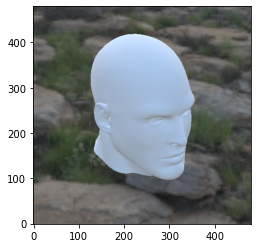

In [5]:
import matplotlib.pyplot as plt
plt.imshow((ref_imgs[7,...,:-1].clip(0,1).pow(1/2.2)).cpu().numpy(), origin='lower')

# 2. Parameterizing

Now it's time to setup the optimization. First, let us import what we need. We need an optimizer, `AdamUniform`, and the functions that allow us to convert back and forth between vertex positions and their parameterization.

In [6]:
steps = 10000 # Number of optimization steps
step_size = 3e-2 # Step size
lambda_ = 19 # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_*L)

Now we need to parameterize our shape. 

In [18]:
#from src.mesh.ellipsoid import Ellipsoid
#from src.mesh.geoid import Geoid
from src.mesh.cube import 
from argparse import Namespace

opt = Namespace(
    n = 82,
    nfc=8, 
    min_nfc=8, 
    ker_size=3,
    num_layer=5,
    stride=1,
    padd_size=0,
    nc_im=3,
)

n = 16
cube = NetCube(n, opt, kernel=7, sigma=2).cuda()

#radii = torch.rand(3, device=v_ref.device, requires_grad=True)
v, f = cube()
# n_ref = compute_face_normals(v_ref, f_ref)
[f.shape for f in [v, f]]

[torch.Size([1536, 3]), torch.Size([3068, 3])]

Let's initialize our optimizer, `AdamUniform`

In [19]:
from largesteps.optimize import AdamUniform

In [20]:
#u.requires_grad = True

#opt = AdamUniform(cube.parameters(), step_size)
opt = torch.optim.Adam(cube.parameters(), step_size)

In [21]:
# Dictionary that is returned in the end, contains useful information for debug/analysis
v_steps = torch.zeros((steps+1, *v.shape))#, device='cuda')
losses = torch.zeros(steps+1)#, device='cuda')

# 3. Running the optimization

And now we can run our optimization. The only difference with "regular" optimization here is the call to `from_differential` in the loop body, that converts the parameterization to vertex coordinates. The rest of the optimization pipeline is unchanged.

In [22]:
opt.zero_grad()

# Optimization loop
for it in trange(steps):
    #v, f = ellipsoid(torch.sigmoid(radii) * 2.)
    #v, f = geoid()
    v, f = cube()
    # Recompute vertex normals
    face_normals = compute_face_normals(v, f)
    n = compute_vertex_normals(v, f, face_normals)

    # Render images
    v, n, f = [f.contiguous()  for f in [v, n, f]]
    opt_imgs = renderer.render(v, n, f)

    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()

    # Record optimization state for later processing
    with torch.no_grad():
        losses[it] = loss.cpu()
        v_steps[it] = v.cpu()

    # Backpropagate
    opt.zero_grad()
    loss.backward()
    
    # Update parameters
    opt.step()

100%|██████████| 10/10 [00:00<00:00, 28.82it/s]


In [23]:
with torch.no_grad():
    # Render images
    opt_imgs = renderer.render(v, n, f)
    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()
    losses[-1] = loss
    v_steps[-1] = v

# 4. Visualizing the results

In [24]:
from meshplot import plot
from ipywidgets import interact
import numpy as np

In [25]:
v_numpy = v_steps.cpu().numpy()
f_numpy = f.cpu().numpy()

In [26]:
shading_params = {
    "width": 600, "height": 600,
    "antialias": True,
    "colormap": "viridis",
    "wireframe": True, "wire_width": 0.03, "wire_color": "black"
}

Let's plot the loss:

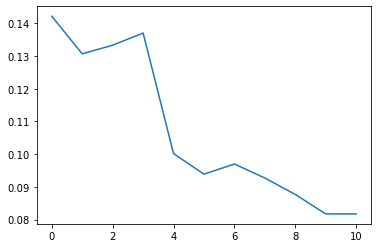

In [27]:
plt.plot(losses.cpu().numpy())

And visualize the mesh across iterations:

In [28]:
@interact(it=(0, steps-1))
def plot_verts(it):
    plot(v_numpy[it], f_numpy, shading=shading_params)

interactive(children=(IntSlider(value=4, description='it', max=9), Output()), _dom_classes=('widget-interact',…

In [35]:
import pytorch3d